## Imports

In [1]:
import sys
import os
import warnings
import json
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from gluonts.dataset.repository.datasets import get_dataset

sys.path.append('../')

/var/folders/9z/qk2z_2yx52x3vny8hmx1wj2c0000gp/T/ipykernel_98282/3961981489.py:7: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
/Users/eliseev_s/anaconda3/envs/env1/lib/python3.9/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/Users/eliseev_s/anaconda3/envs/env1/lib/python3.9/site-packages/gluonts/dataset/artificial/_base.py:84: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  self.freq: BaseOffset = t

In [2]:
warnings.filterwarnings('ignore')

## Read Datasets

### Initital datasets

In [3]:
exchange = get_dataset("exchange_rate", regenerate=False)

solar = get_dataset("solar_nips", regenerate=False)

electricity = get_dataset("electricity_nips", regenerate=False)

### Targets/forecasts

In [4]:
TIME_GRAD_PATH = "../time_grad/notebooks/reports/predictions"

MAF_PATH = "../trans_maf/notebooks/reports/maf/predictions"

DATASETS = ["solar", "electricity", "exchange"]

In [5]:
os.listdir(os.path.join(TIME_GRAD_PATH))

['forecasts.json',
 'forecasts_targets.pickle',
 'metrics.parquet',
 'agg_metrics__electricity.json',
 'forecasts__exchange.pickle',
 'targets__exchange.pickle',
 'agg_metrics__exchange.json',
 'agg_metrics__solar.json',
 'targets__solar.pickle',
 'targets__electricity.pickle',
 'forecasts__electricity.pickle',
 'forecasts__solar.pickle']

### Metrics

In [6]:
models = []
metrics = []
metrics_names = []
datasets = []

for model_path, model_name in zip([TIME_GRAD_PATH, MAF_PATH], ['time_grad', 'trans_maf']):
    for dataset in DATASETS:
        with open(os.path.join(model_path, f'agg_metrics__{dataset}.json')) as f:
            data = json.load(f)

            for metric in ["MAPE", "RMSE", "m_sum_mean_wQuantileLoss"]:
                models.append(model_name)
                metrics.append(data[metric])
                metrics_names.append(metric)
                datasets.append(dataset)

metrics_df = pd.DataFrame({
    "model": models, 
    "metric": metrics,
    "metric_name": metrics_names,
    "dataset": datasets
})

metrics_df["metric_name"] = metrics_df["metric_name"].replace({
    "m_sum_mean_wQuantileLoss": "CRPS_sum"
})

In [7]:
# save metrics dataframe

for model_path, model_name in zip([TIME_GRAD_PATH, MAF_PATH], ['time_grad', 'trans_maf']):  
    metrics_df[metrics_df['model'] == model_name].to_parquet(os.path.join(model_path, 'metrics.parquet'))

### Predictions

In [8]:
forecasts = {}

for model_path, model_name in zip([MAF_PATH, TIME_GRAD_PATH], ['trans_maf', 'time_grad']):

    forecasts[model_name] = {}
    
    for dataset in DATASETS:
        forecasts[model_name][dataset] = {}
    
        for ts in ["targets", "forecasts"]:
    
            with open(os.path.join(model_path, f'{ts}__{dataset}.pickle'), "rb") as fp:
                data = pickle.load(fp)

            forecasts[model_name][dataset][ts] = data

In [9]:
# save forecasts and targets in union file

for model_path, model_name in zip([TIME_GRAD_PATH, MAF_PATH], ['time_grad', 'trans_maf']):  
    with open(os.path.join(model_path, f"forecasts_targets.pickle"), 'wb') as handle:
        pickle.dump(forecasts[model_name], handle, protocol=pickle.HIGHEST_PROTOCOL)

## Metrics visualisation

In [10]:
all_metrics = {}

for metric in ["MAPE", "RMSE", "CRPS_sum"]:
    all_metrics[metric] = metrics_df[metrics_df["metric_name"] == metric] 

In [11]:
for m in all_metrics.keys():
    print(m)
    display(all_metrics[m].sort_values(by=['dataset']).set_index(['metric_name', 'dataset', 'model']))

MAPE


metric
metric_name dataset     model              
MAPE        electricity time_grad  0.159901
                        trans_maf  0.177546
            exchange    time_grad  0.024128
                        trans_maf  0.011794
            solar       time_grad  5.886447
                        trans_maf  4.454861

RMSE


metric
metric_name dataset     model                
RMSE        electricity time_grad  774.694204
                        trans_maf  683.922669
            exchange    time_grad    0.026230
                        trans_maf    0.013451
            solar       time_grad   30.445203
                        trans_maf   32.883633

CRPS_sum


metric
metric_name dataset     model              
CRPS_sum    electricity time_grad  0.028536
                        trans_maf  0.038708
            exchange    time_grad  0.008578
                        trans_maf  0.006008
            solar       time_grad  0.382608
                        trans_maf  0.368967

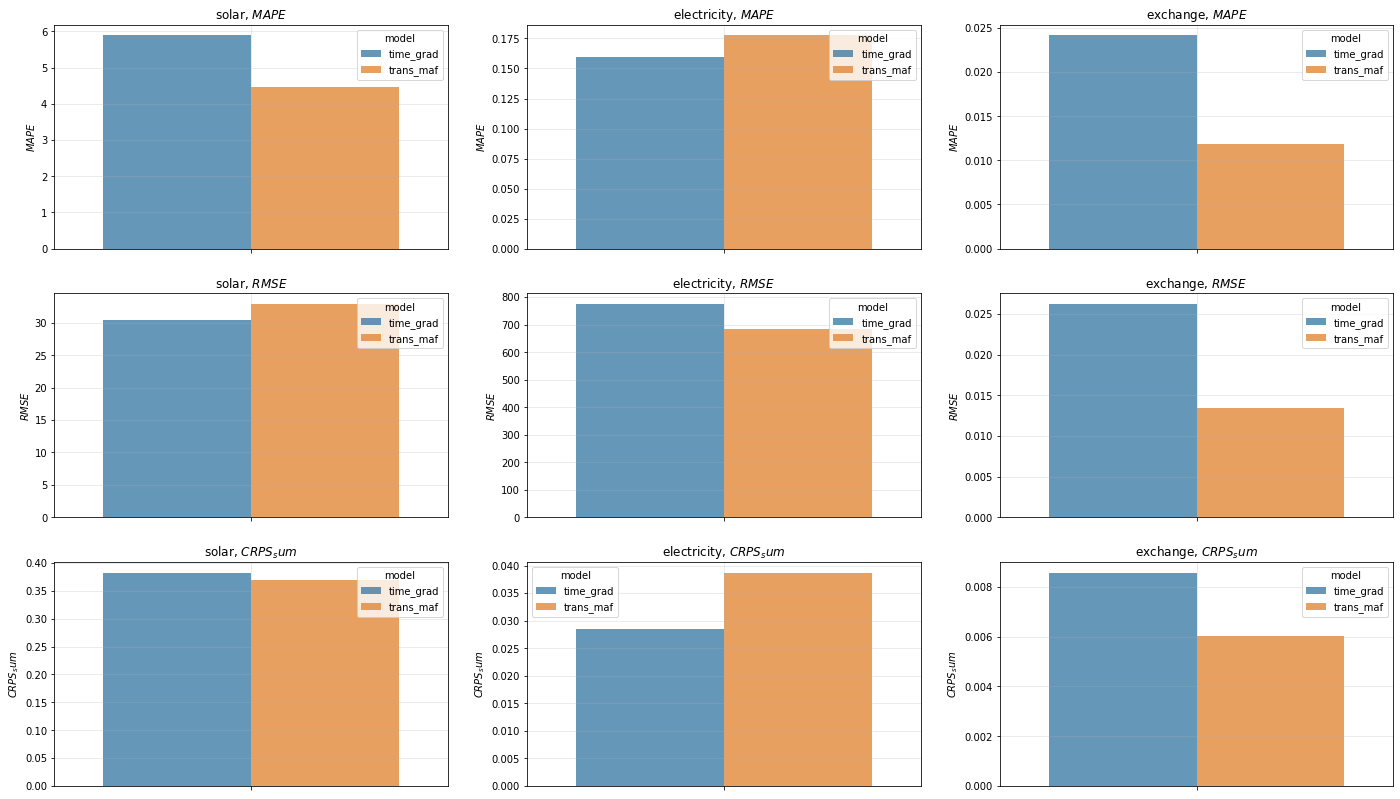

In [12]:
fig, ax = plt.subplots(3, 3, figsize=(24, 14))

for idx, metric in enumerate(all_metrics):
     
    df = all_metrics[metric]

    for jdx, dataset in enumerate(DATASETS):
        sns.barplot(
            data=df[df["dataset"] == dataset], 
            y="metric",
            hue="model",
            alpha=0.75,
            ax=ax[idx][jdx], 
            width=0.75
        )

        ax[idx][jdx].set_title(f"{dataset}, ${metric}$")
        ax[idx][jdx].grid(alpha=0.3)
        ax[idx][jdx].set_ylabel(f"${metric}$")

## Profiles

In [13]:
def dataset_summary(dataset, targets, forecasts):
    print(f"freq: {dataset.metadata.freq}")
    print(f"prediction length: {dataset.metadata.prediction_length}")
    print(f"n_components: {targets.shape[1]}\n")

    print(f"train start: {targets.index[0]}")
    print(f"train end: {targets.index[-1]}")
    print(f"length: {len(targets)}\n")

    print(f"test start: {forecasts.index[0]}")
    print(f"test end: {forecasts.index[-1]}")
    print(f"length: {len(forecasts)}")

In [14]:
def to_pandas(forecasts, freq):
    """
    Transform Gluonts Dataset to Pandas
    """
    whole_test = []

    for i in range(len(forecasts)):

        forecast_length = forecasts[i].samples.shape[1]

        for idx, j in enumerate(forecasts[i].samples):

            dates = pd.date_range(forecasts[i].start_date.to_timestamp(), freq=freq, periods=forecast_length)

            df = pd.DataFrame(j, index=dates)

            df['sample'] = idx

            df[df < 0] = 0

            whole_test.append(df)

    whole_test = pd.concat(whole_test)

    return whole_test

In [15]:
def visualize_targets(targets: pd.DataFrame, name: str):
    """
    Targets visualisation
    """
    targets.plot(figsize=(24, 4), linewidth=0.75)

    plt.grid(alpha=0.3)

    plt.title(f"{name} {targets.shape[1]} components [target].")

    plt.show()

### Solar

#### Dataset Summary

In [153]:
# targets
solar_targets = forecasts['trans_maf']['solar']['targets']

# trans maf forecasts
solar_forecasts_maf = to_pandas(forecasts['trans_maf']['solar']['forecasts'], freq=solar.metadata.freq)

# time grad forecasts
solar_forecasts_tg = to_pandas(forecasts['time_grad']['solar']['forecasts'], freq=solar.metadata.freq)

# test length
solar_test_length = len(solar_forecasts_maf[solar_forecasts_maf['sample'] == 1])

# dataset summary
dataset_summary(solar, solar_targets[0], solar_forecasts_maf[solar_forecasts_maf['sample'] == 1])

freq: H
prediction length: 24
n_components: 137

train start: 2006-01-01 00:00
train end: 2006-10-21 00:00
length: 7033

test start: 2006-10-20 01:00:00
test end: 2006-10-27 00:00:00
length: 168


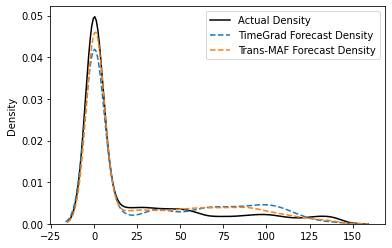

In [154]:
f_maf = solar_forecasts_maf.drop('sample', axis=1).groupby(solar_forecasts_maf.index).median().values.flatten()
f_tg = solar_forecasts_tg.drop('sample', axis=1).groupby(solar_forecasts_tg.index).median().values.flatten()
t = solar_targets[-1][-int(solar_test_length):].values.flatten()

plt.figure(figsize=(6, 4))

sns.kdeplot(t[
    (t < np.percentile(t, 95)),
], fill=False, label=f"Actual Density", color='black')

sns.kdeplot(f_tg[
    (f_tg < np.percentile(t, 95)),
], fill=False, label="TimeGrad Forecast Density", linestyle='--')

sns.kdeplot(f_maf[
    (f_maf < np.percentile(t, 95)),
], fill=False, label="Trans-MAF Forecast Density", linestyle='--')

# plt.title('Фактическая и прогнозная плотность распределения [Solar]', fontsize=12)
plt.legend()
plt.show()

#### Train/test periods

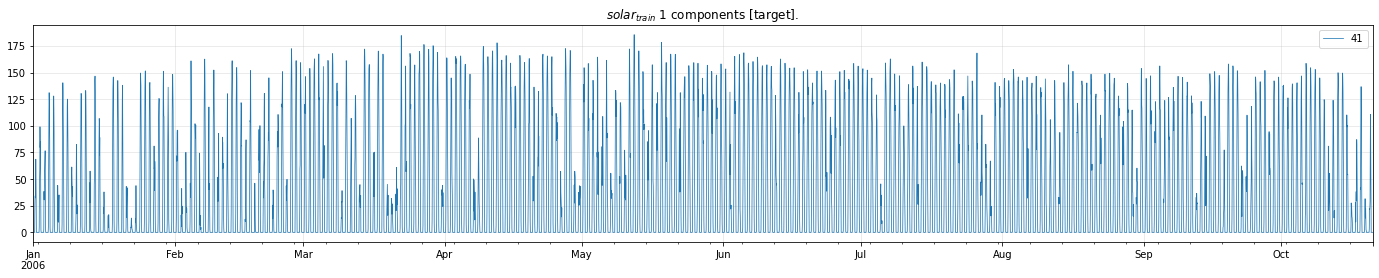

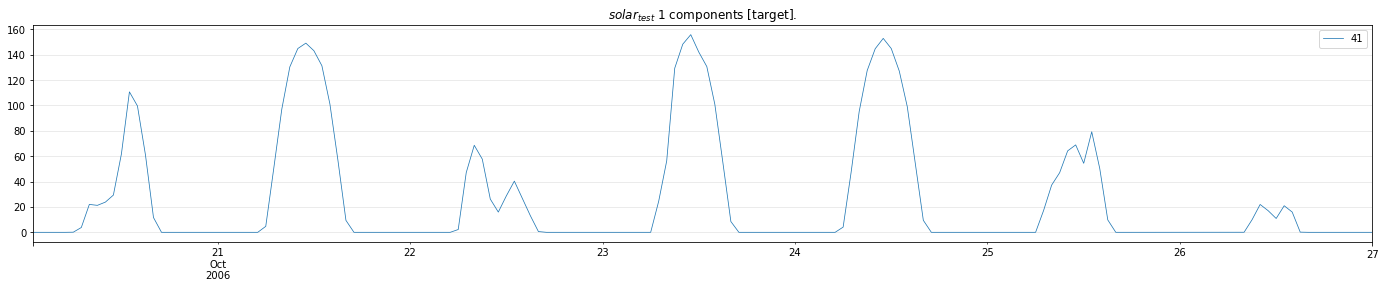

In [77]:
n = 1

solar_components = np.random.choice(range(solar_targets[0].shape[1]), size=n)

visualize_targets(solar_targets[0][solar_components], '$solar_{train}$')
visualize_targets(solar_targets[-1][solar_components].iloc[-solar_test_length:, :], '$solar_{test}$')

#### Actual/forecast visualisation

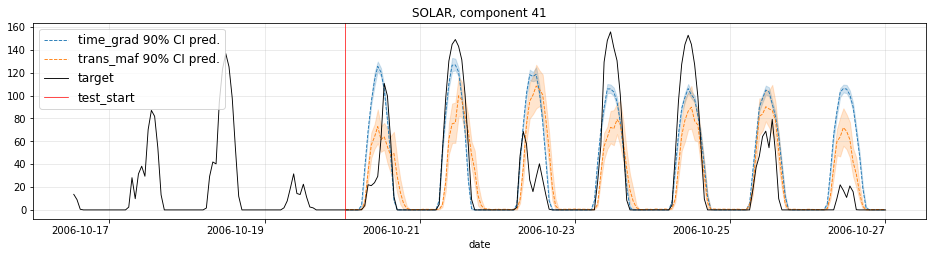

In [78]:
plt.figure(figsize=(16, 4))
for idx, component in enumerate(solar_components):
    sns.lineplot(
        np.round(solar_forecasts_tg[component]),
        label='time_grad 90% CI pred.', linestyle='--', linewidth=0.9, #ax=axs[idx]
    )
    
    sns.lineplot(
        np.round(solar_forecasts_maf[component]),
        label='trans_maf 90% CI pred.', linestyle='--', linewidth=0.9, #ax=axs[idx]
    )

    solar_targets[-1][component][-int(solar_test_length*1.5):].plot(
        label='target', color='black', linewidth=0.9, #ax=axs[idx]
        )
    plt.axvline(solar_forecasts_maf.index[0], label='test_start', color='red', linewidth=0.7)


    plt.legend(loc='upper left', fontsize=12)
    plt.grid(alpha=0.3)
    plt.title(f"SOLAR, component {component}")
    plt.tick_params(axis='x', rotation=0)
    plt.xlabel('date')
    plt.ylabel('')

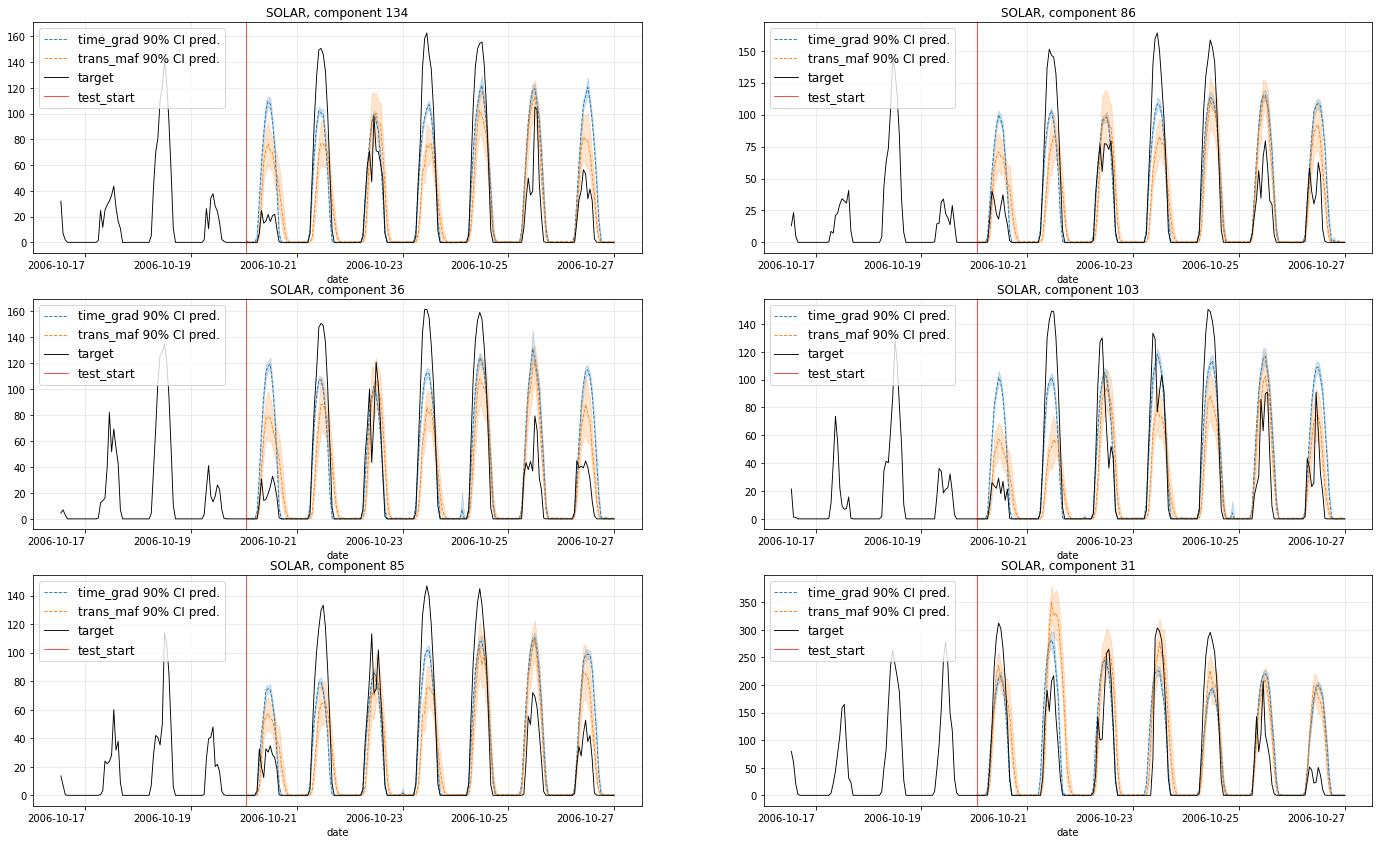

In [99]:
n = 6
solar_components = np.random.choice(range(solar_targets[0].shape[1]), size=n)

fig, ax = plt.subplots(3, 2, figsize=(24, 16))

axs = ax.flatten()

for idx, component in enumerate(solar_components):
    sns.lineplot(
        np.round(solar_forecasts_tg[component]),
        label='time_grad 90% CI pred.', linestyle='--', linewidth=0.9, ax=axs[idx]
    )
    
    sns.lineplot(
        np.round(solar_forecasts_maf[component]),
        label='trans_maf 90% CI pred.', linestyle='--', linewidth=0.9, ax=axs[idx]
    )

    solar_targets[-1][component][-int(solar_test_length*1.5):].plot(label='target', color='black', linewidth=0.9, ax=axs[idx])
    axs[idx].axvline(solar_forecasts_maf.index[0], label='test_start', color='red', linewidth=0.7)


    axs[idx].legend(loc='upper left', fontsize=12)
    axs[idx].grid(alpha=0.3)
    axs[idx].set_title(f"SOLAR, component {component}")
    axs[idx].tick_params(axis='x', rotation=0)
    axs[idx].set_xlabel('date')
    axs[idx].set_ylabel('')

### Electricity

#### Dataset summary

In [26]:
# targets
electricity_targets = forecasts['trans_maf']['electricity']['targets']

# trans maf forecasts
electricity_forecasts_maf = to_pandas(forecasts['trans_maf']['electricity']['forecasts'], freq=electricity.metadata.freq)

# time grad forecasts
electricity_forecasts_tg = to_pandas(forecasts['time_grad']['electricity']['forecasts'], freq=electricity.metadata.freq)

# test length
el_test_length = len(electricity_forecasts_maf[electricity_forecasts_maf['sample'] == 1])

# dataset summary
dataset_summary(electricity, electricity_targets[0], electricity_forecasts_maf[electricity_forecasts_maf['sample'] == 1])

freq: H
prediction length: 24
n_components: 370

train start: 2014-03-19 09:00
train end: 2014-09-02 00:00
length: 4000

test start: 2014-09-01 01:00:00
test end: 2014-09-08 00:00:00
length: 168


In [155]:
f_maf = electricity_forecasts_maf.drop('sample', axis=1).groupby(electricity_forecasts_maf.index).median().values.flatten()
f_tg = electricity_forecasts_tg.drop('sample', axis=1).groupby(electricity_forecasts_tg.index).median().values.flatten()
t = electricity_targets[-1][-int(el_test_length):].values.flatten()

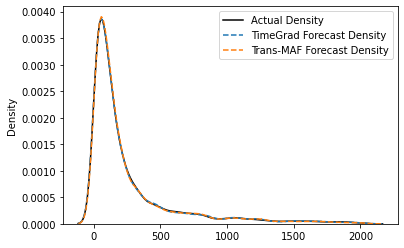

In [156]:
plt.figure(figsize=(6, 4))

sns.kdeplot(t[
    (t < np.percentile(t, 95)),
], fill=False, label=f"Actual Density", color='black')

sns.kdeplot(f_tg[
    (f_tg < np.percentile(t, 95)),
], fill=False, label="TimeGrad Forecast Density", linestyle='--')

sns.kdeplot(f_maf[
    (f_maf < np.percentile(t, 95)),
], fill=False, label="Trans-MAF Forecast Density", linestyle='--')

# plt.title('Фактическая и прогнозная плотность распределения [Electricity]', fontsize=12)
plt.legend()
plt.show()

#### Train/test periods

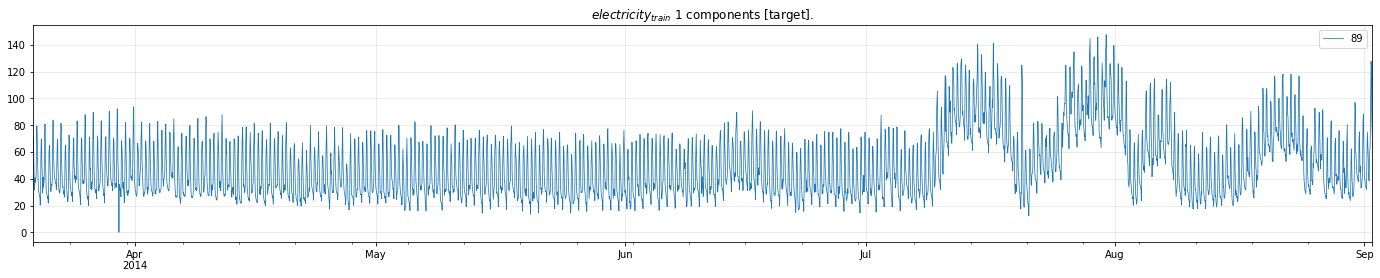

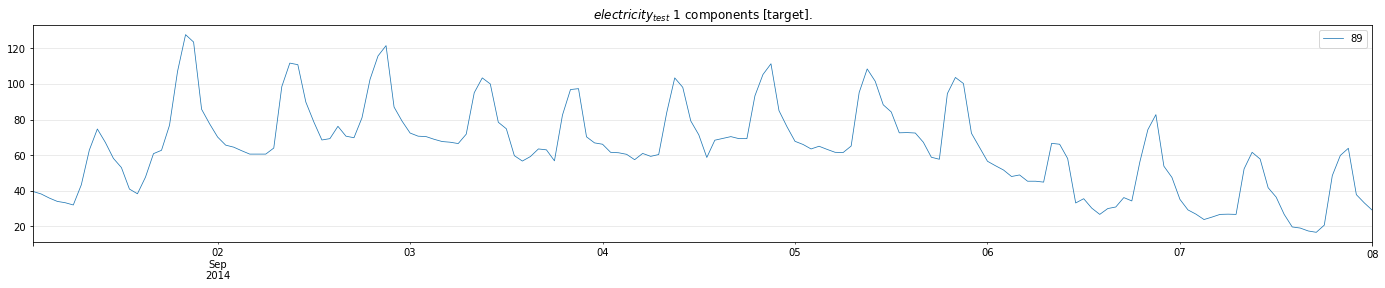

In [81]:
n = 1

electricity_components = np.random.choice(range(electricity_targets[0].shape[1]), size=n)

visualize_targets(electricity_targets[0][electricity_components], '$electricity_{train}$')
visualize_targets(electricity_targets[-1][electricity_components].iloc[-el_test_length:, :], '$electricity_{test}$')

#### Actual/forecast visualisation

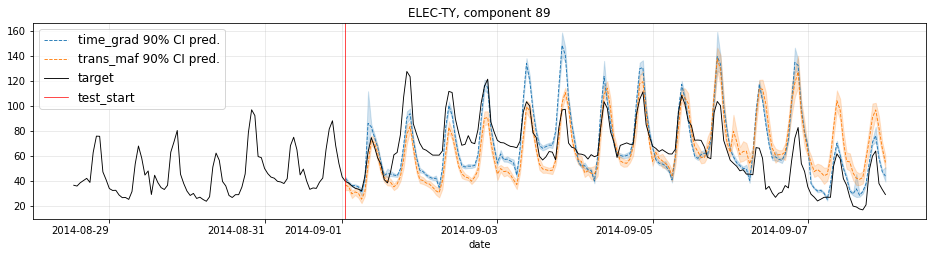

In [85]:
plt.figure(figsize=(16, 4))

for idx, component in enumerate(electricity_components):
    sns.lineplot(
        np.round(electricity_forecasts_tg[component]),
        label='time_grad 90% CI pred.', linestyle='--', linewidth=0.9, #ax=axs[idx]
    )
    
    sns.lineplot(
        np.round(electricity_forecasts_maf[component]),
        label='trans_maf 90% CI pred.', linestyle='--', linewidth=0.9, #ax=axs[idx]
    )

    electricity_targets[-1][component][-int(el_test_length*1.5):].plot(
        label='target', color='black', linewidth=0.9, #ax=axs[idx]
        )
    plt.axvline(electricity_forecasts_maf.index[0], label='test_start', color='red', linewidth=0.7)


    plt.legend(loc='upper left', fontsize=12)
    plt.grid(alpha=0.3)
    plt.title(f"ELEC-TY, component {component}")
    plt.tick_params(axis='x', rotation=0)
    plt.xlabel('date')
    plt.ylabel('')

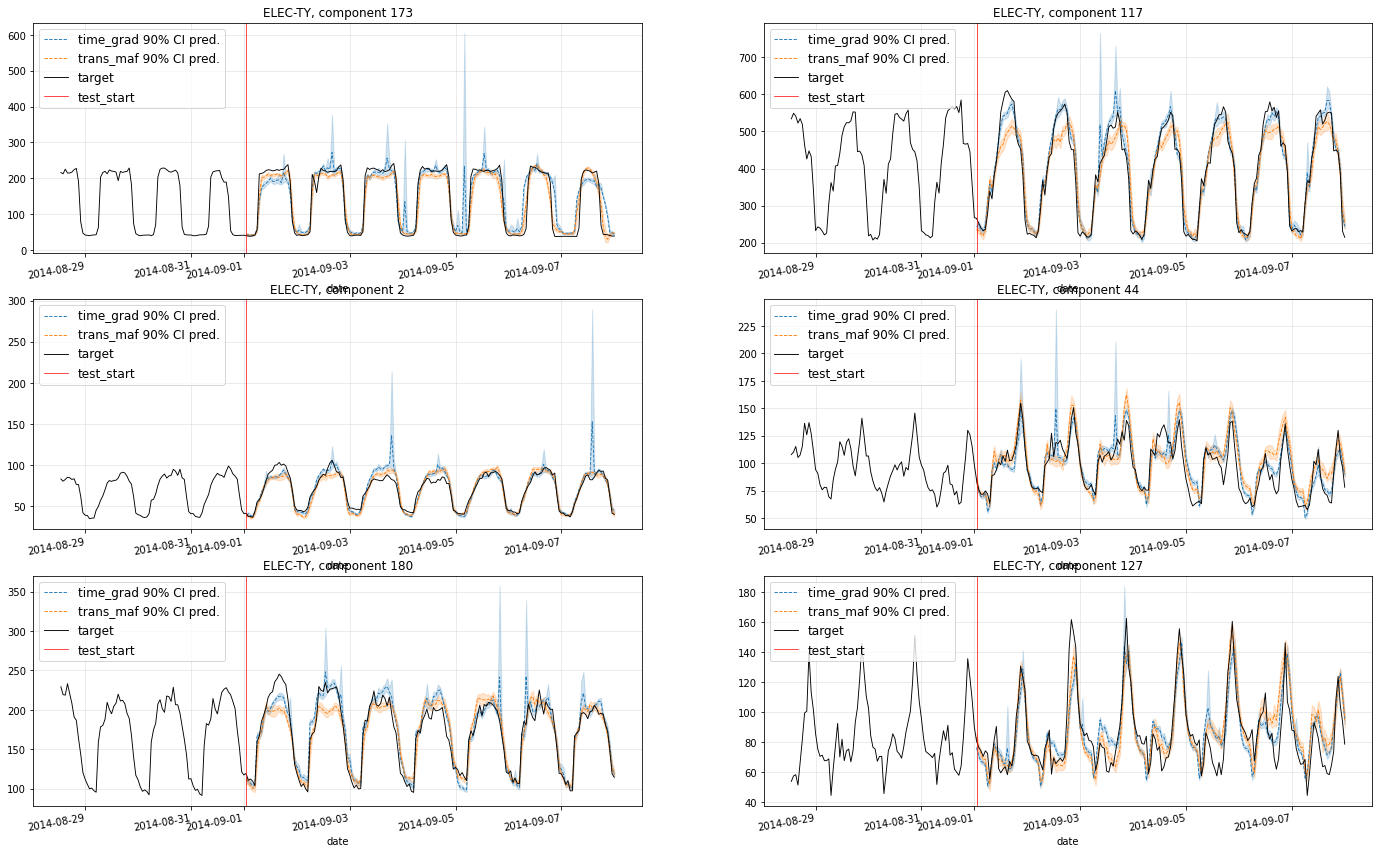

In [100]:
n = 6
electricity_components = np.random.choice(range(electricity_targets[0].shape[1]), size=n)

fig, ax = plt.subplots(3, 2, figsize=(24, 16))


axs = ax.flatten()

for idx, component in enumerate(electricity_components):
    sns.lineplot(
        electricity_forecasts_tg[component],
        label='time_grad 90% CI pred.', linestyle='--', linewidth=0.9, ax=axs[idx]
    )
    sns.lineplot(
        electricity_forecasts_maf[component],
        label='trans_maf 90% CI pred.', linestyle='--', linewidth=0.9, ax=axs[idx]
    )

    electricity_targets[-1][component][-int(el_test_length*1.5):].plot(label='target', color='black', linewidth=0.9, ax=axs[idx])
    axs[idx].axvline(electricity_forecasts_maf.index[0], label='test_start', color='red', linewidth=0.7)


    axs[idx].legend(loc='upper left', fontsize=12)
    axs[idx].grid(alpha=0.3)
    axs[idx].set_title(f"ELEC-TY, component {component}")
    axs[idx].tick_params(axis='x', rotation=10)
    axs[idx].set_xlabel('date')
    axs[idx].set_ylabel('')
    

### Exchange

#### Dataset summary

In [75]:
# targets
exchange_targets = forecasts['trans_maf']['exchange']['targets']

# trans maf forecasts
exchange_forecasts_maf = to_pandas(forecasts['trans_maf']['exchange']['forecasts'], freq=exchange.metadata.freq)

# time grad forecasts
exchange_forecasts_tg = to_pandas(forecasts['time_grad']['exchange']['forecasts'], freq=exchange.metadata.freq)

# test length
ex_test_size = len(exchange_forecasts_maf[exchange_forecasts_maf['sample'] == 1])

# dataset summary
dataset_summary(exchange, exchange_targets[0], exchange_forecasts_maf[exchange_forecasts_maf['sample'] == 1])

freq: 1B
prediction length: 30
n_components: 8

train start: 1990-01-01
train end: 2013-05-20
length: 6101

test start: 2013-04-09 00:00:00
test end: 2013-11-04 00:00:00
length: 150


In [151]:
f_maf = exchange_forecasts_maf.drop('sample', axis=1).groupby(exchange_forecasts_maf.index).median().values.flatten()
f_tg = exchange_forecasts_tg.drop('sample', axis=1).groupby(exchange_forecasts_tg.index).median().values.flatten()
t = exchange_targets[-1][-int(ex_test_size):].values.flatten()

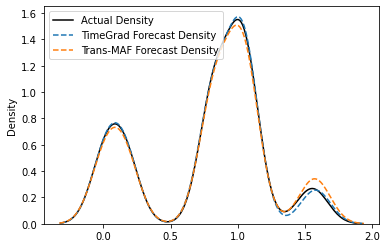

In [152]:
plt.figure(figsize=(6, 4))

sns.kdeplot(t[
    (t < np.percentile(t, 95)),
], fill=False, label=f"Actual Density", color='black')

sns.kdeplot(f_tg[
    (f_tg < np.percentile(t, 95)),
], fill=False, label="TimeGrad Forecast Density", linestyle='--')

sns.kdeplot(f_maf[
    (f_maf < np.percentile(t, 95)),
], fill=False, label="Trans-MAF Forecast Density", linestyle='--')

# plt.title('Фактическая и прогнозная плотность распределения [Exchange]', fontsize=12)
plt.legend()
plt.show()

#### Train/test periods

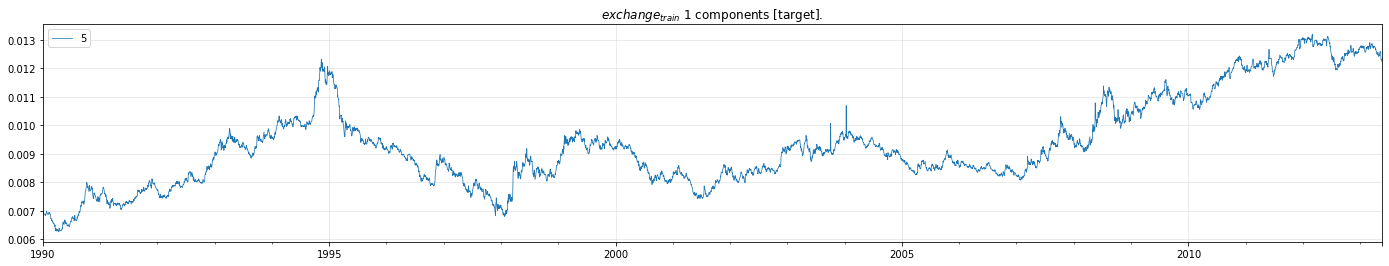

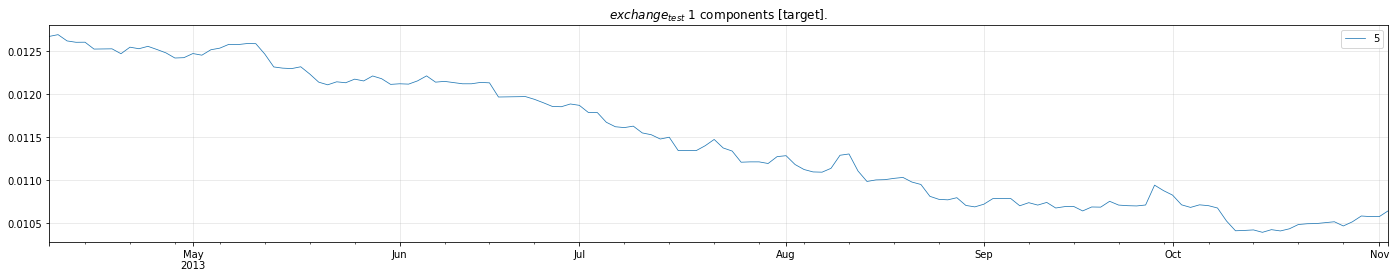

In [95]:
n = 1

exchange_components = np.random.choice(range(exchange_targets[0].shape[1]), size=n, replace=False)

visualize_targets(exchange_targets[0][exchange_components], '$exchange_{train}$')
visualize_targets(exchange_targets[-1][exchange_components].iloc[-ex_test_size:, :], '$exchange_{test}$')

#### Actual/forecast visualisation

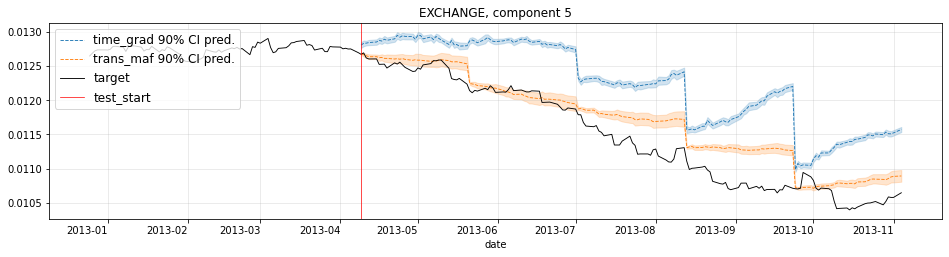

In [97]:
plt.figure(figsize=(16, 4))

for idx, component in enumerate(exchange_components):
    sns.lineplot(
        exchange_forecasts_tg[component],
        label='time_grad 90% CI pred.', linestyle='--', linewidth=0.9, #ax=axs[idx]
    )
    
    sns.lineplot(
        exchange_forecasts_maf[component],
        label='trans_maf 90% CI pred.', linestyle='--', linewidth=0.9, #ax=axs[idx]
    )

    exchange_targets[-1][component][-int(ex_test_size*1.5):].plot(
        label='target', color='black', linewidth=0.9, #ax=axs[idx]
        )
    plt.axvline(exchange_forecasts_maf.index[0], label='test_start', color='red', linewidth=0.7)


    plt.legend(loc='upper left', fontsize=12)
    plt.grid(alpha=0.3)
    plt.title(f"EXCHANGE, component {component}")
    plt.tick_params(axis='x', rotation=0)
    plt.xlabel('date')
    plt.ylabel('')

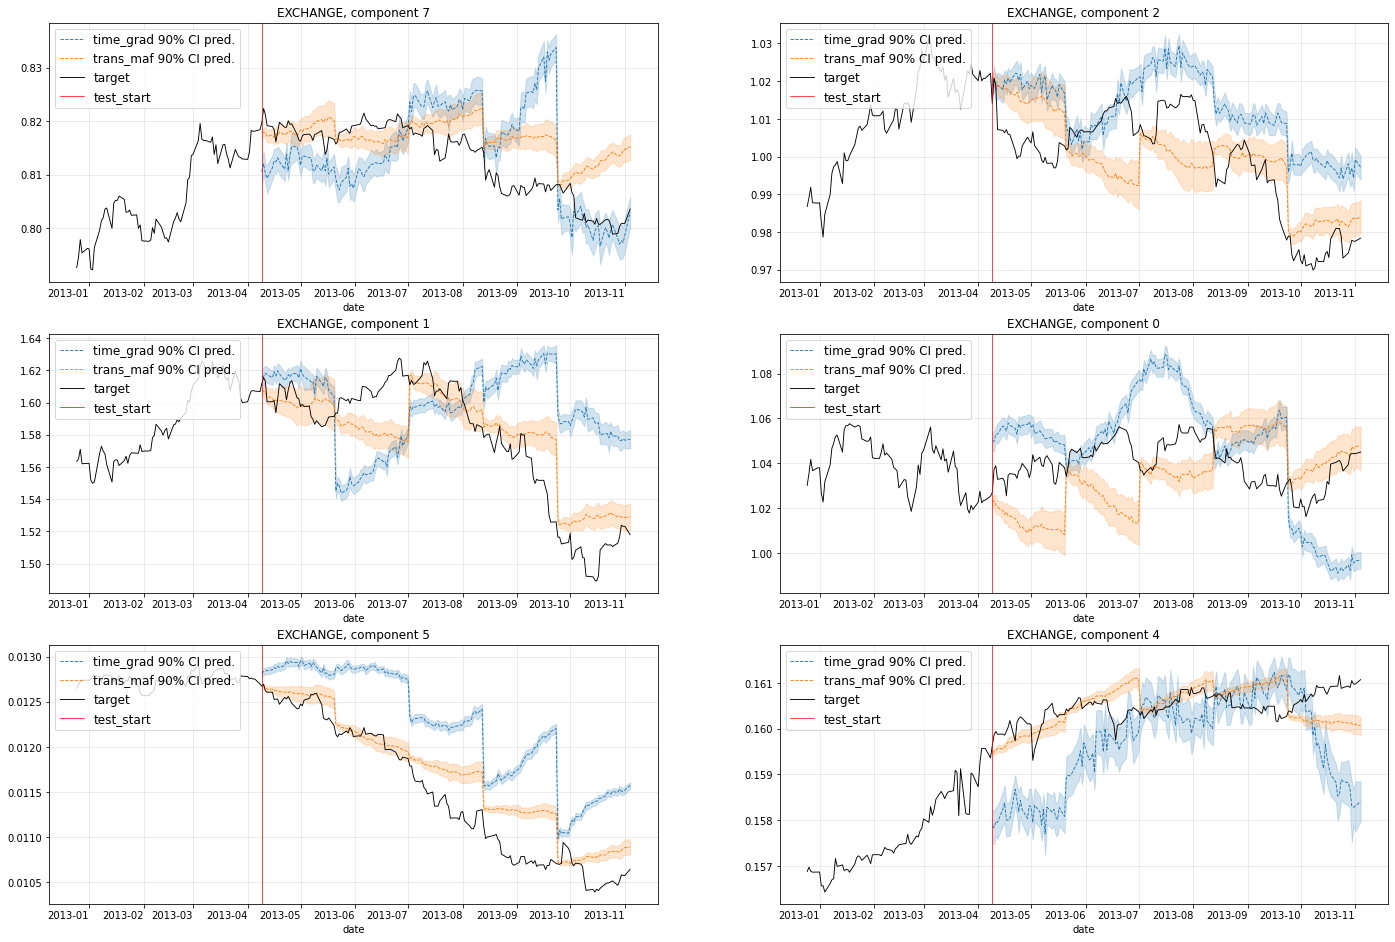

In [101]:
n = 6
exchange_components = np.random.choice(range(exchange_targets[0].shape[1]), size=n, replace=False)

fig, ax = plt.subplots(3, 2, figsize=(24, 18))


axs = ax.flatten()

for idx, component in enumerate(exchange_components):
    sns.lineplot(
        exchange_forecasts_tg[component],
        label='time_grad 90% CI pred.', linestyle='--', linewidth=0.9, ax=axs[idx]
    )
    sns.lineplot(
        exchange_forecasts_maf[component],
        label='trans_maf 90% CI pred.', linestyle='--', linewidth=0.9, ax=axs[idx]
    )

    exchange_targets[-1][component][-int(ex_test_size*1.5):].plot(label='target', color='black', linewidth=0.9, ax=axs[idx])
    axs[idx].axvline(exchange_forecasts_maf.index[0], label='test_start', color='red', linewidth=0.7)
    

    axs[idx].legend(loc='upper left', fontsize=12)
    axs[idx].grid(alpha=0.3)
    axs[idx].set_title(f"EXCHANGE, component {component}")
    axs[idx].tick_params(axis='x', rotation=0)
    axs[idx].set_xlabel('date')
    axs[idx].set_ylabel('')